In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, BatchNormalization, Dense, Flatten, Softmax
from tensorflow.keras import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
# Convert y_train into one-hot format
temp = []
for i in range(len(y_train)):
    temp.append(to_categorical(y_train[i], num_classes=10)[0])
y_train = np.array(temp)
# Convert y_test into one-hot format
temp = []
for i in range(len(y_test)):    
    temp.append(to_categorical(y_test[i], num_classes=10)[0])
y_test = np.array(temp)

In [4]:
#reshaping
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [5]:
inputs = Input(shape=(32,32,3))
out = BatchNormalization()(inputs)
out = Flatten()(out)
out = Dense(10, activation=None)(out)
out = Softmax()(out)
full_model = Model(inputs, out)

In [6]:
full_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
    )

In [7]:
full_model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/15


2022-12-08 23:31:46.750637: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


391/391 [==============================] - 2s 6ms/step - loss: 1.9325 - acc: 0.3411 - val_loss: 1.8102 - val_acc: 0.3692
Epoch 2/15
391/391 [==============================] - 3s 7ms/step - loss: 1.7884 - acc: 0.3842 - val_loss: 1.8120 - val_acc: 0.3723
Epoch 3/15
391/391 [==============================] - 2s 6ms/step - loss: 1.7473 - acc: 0.3989 - val_loss: 1.7791 - val_acc: 0.3862
Epoch 4/15
391/391 [==============================] - 3s 7ms/step - loss: 1.7211 - acc: 0.4124 - val_loss: 1.7577 - val_acc: 0.3897
Epoch 5/15
391/391 [==============================] - 2s 6ms/step - loss: 1.7079 - acc: 0.4144 - val_loss: 1.7662 - val_acc: 0.3864
Epoch 6/15
391/391 [==============================] - 2s 5ms/step - loss: 1.6977 - acc: 0.4164 - val_loss: 1.7524 - val_acc: 0.3932
Epoch 7/15
391/391 [==============================] - 2s 5ms/step - loss: 1.6914 - acc: 0.4190 - val_loss: 1.7497 - val_acc: 0.3873
Epoch 8/15
391/391 [==============================] - 2s 5ms/step - loss: 1.6852 - acc:

In [8]:
model = Model(full_model.input, full_model.layers[1].output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
Total params: 12
Trainable params: 6
Non-trainable params: 6
_________________________________________________________________


In [9]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
converter._experimental_disable_per_channel = True
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmp9hh3wvtw/assets


/Users/sty/miniforge3/envs/tf-cpu/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-08 23:32:20.637174: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-08 23:32:20.637185: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-08 23:32:20.637320: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmp9hh3wvtw
2022-12-08 23:32:20.637717: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-08 23:32:20.637722: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmp9hh3wvtw
2022-12-08 23:32:20.638

In [11]:
'''
Create interpreter, allocate tensors
'''
tflite_interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
tflite_interpreter.allocate_tensors()

'''
Check input/output details
'''
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

'''
This gives a list of dictionaries. 
'''
tensor_details = tflite_interpreter.get_tensor_details()

index = -1

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization'][0]
    zero_points = dict['quantization'][1]
    tensor = tflite_interpreter.tensor(i)()

    #print(i, type, tensor_name, scales.shape, zero_points.shape, tensor.shape)
    print(dict)
    if 'FusedBatchNormV32' in tensor_name:
        index = i+1
        zero_point_1 = zero_points
        scale = scales
        print(tensor)

    if i==index:
        zero_point_2 = zero_points

== Input details ==
name: serving_default_input_1:0
shape: [ 1 32 32  3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 32 32  3]
type: <class 'numpy.float32'>
{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32, 32,  3], dtype=int32), 'shape_signature': array([-1, 32, 32,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'model_1/batch_normalization/FusedBatchNormV31', 'index': 1, 'shape': array([3], dtype=int32), 'shape_signature': array([3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0018431608332321048, 127), 'quantization_parameters': {'scales': array([0.00184316], dtype=float32), 'zero_points': array([127], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'model_1/batch_no

INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


In [12]:
zero_point = (zero_point_2-zero_point_1)
scale, zero_point

(0.00397644005715847, 118)

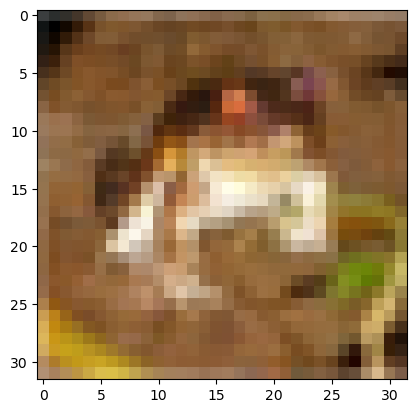

In [13]:
X = X_train[[0]].astype(int)
plt.imshow(X[0])

1/1 [==============================] - 0s 34ms/step


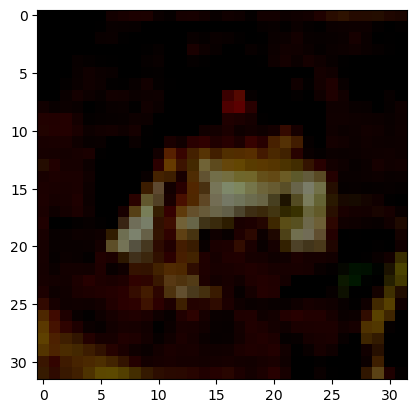

In [14]:
y = model.predict(X)
plt.imshow(y[0])

In [15]:
gamma = model.layers[1].weights[0].numpy()
beta = model.layers[1].weights[1].numpy()
moving_mean = model.layers[1].weights[2].numpy()
moving_var = model.layers[1].weights[3].numpy()
epsilon = model.layers[1].epsilon
gamma, beta, moving_mean, moving_var, epsilon

(array([0.22937886, 0.24656726, 0.24305297], dtype=float32),
 array([ 0.024881  ,  0.01808149, -0.01237541], dtype=float32),
 array([125.08019, 122.74484, 113.73573], dtype=float32),
 array([3967.053 , 3844.8708, 4432.725 ], dtype=float32),
 0.001)

In [16]:
a = gamma/(moving_var+epsilon)**.5
b = beta-gamma*moving_mean/(moving_var+epsilon)**.5
a, b/a

(array([0.00364183, 0.00397644, 0.00365061], dtype=float32),
 array([-118.24818 , -118.197685, -117.12569 ], dtype=float32))

In [17]:
in_json = {
    "in": X.astype(int).flatten().tolist(),
    "zero_point": zero_point,
}

In [18]:
out_json = {
    "scale": scale,
    "out": y.flatten().tolist()
}

In [19]:
import json

In [20]:
with open("batchNormalization_input.json", "w") as f:
    json.dump(in_json, f)

In [21]:
with open("batchNormalization_output.json", "w") as f:
    json.dump(out_json, f)